In [2]:

import numpy as np
import matplotlib.pyplot as plt
from testing.gain_patterns.models import Experiment, ExperimentEntry

exp = Experiment.load_by_name("first")
print(exp)

Experiment(name='first', min_freq=20000, max_freq=50000, freq_spacing=2500, tone_length_us=10000.0, silence_length_us=90000.0, min_azimuth=0, max_azimuth=90, azimuth_spacing=10, trials_per_azimuth=3, sample_rate=192000)


In [26]:
import numpy as np
from wavio import read

from robin.process.analyze import remove_leading_silence
from robin.util import bandpass

rate = 192000
powers_by_azimuth = {}

def extract_samples_spaced_by_silence(signal, sample_length_us, sample_rate, num):
    """
    Extract n samples of known length from the signal, assuming leading silence is removed between samples.

    Parameters:
    signal (ndarray): Input signal array.
    sample_length_us (int): Length of each sample in microseconds.
    sample_rate (int): Number of samples per second in the signal.
    num (int): Number of samples to extract.
    remove_leading_silence (function): Function to remove leading silence from a signal.

    Returns:
    list of ndarray: List of extracted samples.
    """
    # Convert sample length from microseconds to samples
    sample_length_samples = int(sample_rate * sample_length_us / 1e6)

    # Extract samples
    samples = []
    current_signal = signal.copy()
    for _ in range(num):
        # Remove the extracted sample and leading silence from the remaining signal
        current_signal = remove_leading_silence(current_signal[sample_length_samples:], threshold_db=-30)

        if len(current_signal) < sample_length_samples:
            break  # Break if remaining signal is shorter than required sample length

        # Extract the sample
        sample = current_signal[:sample_length_samples]
        samples.append(sample)

    return samples

            
def get_powers_by_freq(exp: Experiment, azimuth: int, trial: int):
    powers_by_freq = {}
    entry = ExperimentEntry(experiment=exp, azimuth=azimuth, trial=trial)
    wav_data = read(entry.wav_file_path).data.flatten().astype(np.int32)
    # tones = extract_samples_spaced_by_silence(
    #     signal=wav_data,
    #     sample_length_us=exp.tone_length_us,
    #     sample_rate=exp.sample_rate,
    #     num=len(exp.frequencies)
    # )
    # if len(tones) != len(exp.frequencies):
    #     print(f"Expected {len(exp.frequencies)} got {len(tones)} tones at azimuth={azimuth}")
    #     return {}
    for idx, freq in enumerate(exp.frequencies):
        half_bw = exp.freq_spacing / 2
        at_freq = bandpass(wav_data, freq - half_bw, freq + half_bw, exp.sample_rate)
        power = np.sum(at_freq ** 2) / len(at_freq)
        powers_by_freq[freq] = power
    return powers_by_freq

def get_powers_by_azimuth(exp: Experiment):
    by_azimuth = {}
    for azimuth in exp.azimuths:
        by_power_all_trials = {}
        for trial in range(exp.trials_per_azimuth):
            for freq, power in get_powers_by_freq(exp, azimuth, trial).items():
                by_power_all_trials.setdefault(freq, [])
                by_power_all_trials[freq].append(power)
        for freq, powers in by_power_all_trials.items():
            by_power_all_trials[freq] = np.max(powers)
        by_azimuth[azimuth] = by_power_all_trials
    return by_azimuth

powers = get_powers_by_azimuth(exp)
powers

{0: {20000: 77243.59219618759,
  22500: 104283.91789779015,
  25000: 62781.65692662403,
  27500: 23997.398601628563,
  30000: 12520.754705506188,
  32500: 8473.584440526634,
  35000: 5674.601796685184,
  37500: 4224.182274171856,
  40000: 4425.395426064434,
  42500: 2751.938165062827,
  45000: 1344.718991855396,
  47500: 1322.057306139993,
  50000: 685.8008235610408},
 10: {20000: 93534.319297986,
  22500: 132002.08633821874,
  25000: 80813.75750484475,
  27500: 26651.808926053644,
  30000: 15617.79004804091,
  32500: 11837.788826637361,
  35000: 8442.175465206357,
  37500: 5308.841632962272,
  40000: 3745.796750730233,
  42500: 2515.40548776591,
  45000: 1516.1652221488898,
  47500: 2012.375366561614,
  50000: 960.4084822505679},
 20: {20000: 79880.86520012234,
  22500: 86603.27456521781,
  25000: 55105.51815326123,
  27500: 18444.857501267135,
  30000: 10428.985842632579,
  32500: 7107.803014784714,
  35000: 5381.246611063784,
  37500: 4174.203105633312,
  40000: 3219.2882722106715,


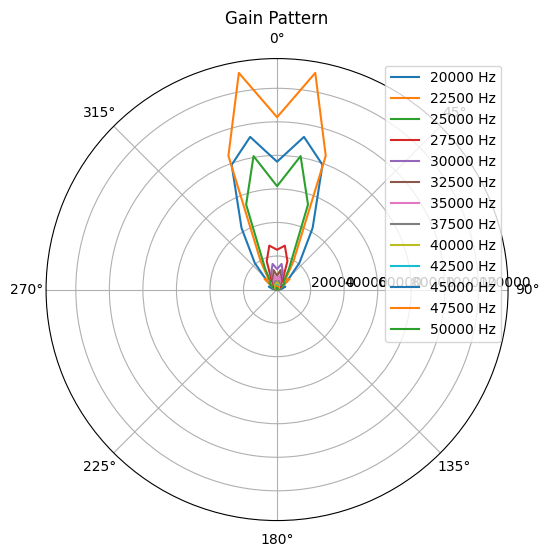

In [25]:
import matplotlib.pyplot as plt
import numpy as np

def plot_gain_pattern(data):
    """
    Plots a radial chart of sound power as a function of azimuth for each frequency.

    Parameters:
    data (dict): Dictionary with outer keys as azimuths, inner keys as frequencies, and values as sound powers.
    """
    # Transform data to frequency -> azimuth -> power
    transformed_data = {}
    for azimuth, freqs in data.items():
        for freq, power in freqs.items():
            if freq not in transformed_data:
                transformed_data[freq] = []
            transformed_data[freq].append((azimuth, power))
            # Add mirrored data
            transformed_data[freq].append((-azimuth, power))

    # Create radial plot
    fig = plt.figure(figsize=(20,6))
    ax = fig.add_subplot(111, polar=True)

    for freq, values in transformed_data.items():
        values.sort()  # Sort by azimuth
        azimuths, powers = zip(*values)
        azimuths = np.radians(azimuths)  # Convert azimuths to radians for plotting

        ax.plot(azimuths, powers, label=f'{freq} Hz')

    ax.set_theta_zero_location('N')  # North at the top
    ax.set_theta_direction(-1)  # Clockwise direction
    ax.set_rlabel_position(90)  # Position of radial labels

    plt.legend(loc='upper right')
    plt.title('Gain Pattern')
    plt.show()


plot_gain_pattern(powers)
